### National Technical University of Athens
### School of Electrical & Computer Engineering
### Course: **Artificial Intelligence**
#### *7th Semester, 2020-2021*
##### Full Name: Christos Tsoufis
##### A.M.: 031 17 176
        
## **Lab 1**

# Τεχνητή Νοημοσύνη: Θέμα 1

    

---



Στόχος του θέματος είναι η εφαρμογή αλγορίθμων αναζήτησης για την εύρεση καλύτερου μονοπατιού σε **λαβυρίνθους** διαστάσεων $N\times N$


**Imports**

In [ ]:
%matplotlib inline

import numpy as np
from queue import LifoQueue
from random import random, shuffle, uniform
import random
import matplotlib.pyplot as plt

import math
from queue import PriorityQueue
import heapq

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML

 **Visualization code**

In [2]:
class visualization:
    def __init__(self, S, F):
        '''
          Η μέθοδος αυτή αρχικοποιεί ένα αντικείμενο τύπου visualization.
          Είσοδος: 
          -> S: το σημείο εκκίνησης της αναζήτησης
          -> F: το σημείο τερματισμού
        '''
        self.S = S
        self.F = F
        self.images = []
    
    def draw_step(self, grid, frontier, expanded_nodes):
        '''
          Η συνάρτηση αυτή καλείται για να σχεδιαστεί ένα frame στο animation (πρακτικά έπειτα από την επέκταση κάθε κόμβου)
          Είσοδος: 
          -> grid: Ένα χάρτης τύπου grid
          -> frontier: Μια λίστα με τους κόμβους που ανήκουν στο μέτωπο της αναζήτησης
          -> expanded_nodes: Μια λίστα με τους κόμβους που έχουν ήδη επεκταθεί
          Επιστρέφει: None
          Η συνάρτηση αυτή πρέπει να καλεστεί τουλάχιστον μια φορά για να μπορέσει να σχεδιαστεί ένα animation (πρεπεί το animation να έχει τουλάχιστον ένα frame).
        '''
        image = np.zeros((grid.N, grid.N, 3), dtype=int)
        image[grid.grid == 0] = [255, 255, 255]
        image[grid.grid == 1] = [0, 0, 0]
        
        for node in expanded_nodes:
            image[node] = [0, 0, 128]

        for node in frontier:
            image[node] = [0, 225, 0]

        image[self.S] = [50, 168, 64]
        image[self.F] = [168, 50, 50]
        self.images.append(image)
    
    def add_path(self, path):
        '''
          Η συνάρτηση αυτή προσθέτει στο τελευταίο frame το βέλτιστο μονοπάτι.
          Είσοδος:
          -> path: Μια λίστα η όποια περιέχει το βέλτιστο μονοπάτι (η οποία πρέπει να περιέχει και τον κόμβο αρχή και τον κόμβο στόχο)
          Έξοδος: None
        '''
        for n in path[1:-1]:
            image = np.copy(self.images[-1])
            image[n] = [66, 221, 245]
            self.images.append(image)
        
    def create_gif(self, fps = 30, repeat_delay = 2000):
        if len(self.images) == 0:
            raise EmptyStackOfImages("Error! You have to call 'draw_step' at  first.")
        fig = plt.figure()
        plt.axis('off')
        ims = []
        for img in self.images:
            img = plt.imshow(img)
            ims.append([img])
        ani = animation.ArtistAnimation(fig, ims, interval=1000//fps, blit=True, repeat_delay= repeat_delay)
        plt.close(fig)
        return ani
        
    def save_gif(self, filename, fps = 30):
        '''
            Η συνάρτηση αυτή ξαναδημιουργεί και αποθηκεύει το animation σε ένα αρχείο.
            Είσοδος:
            -> Το όνομα του αρχείου με κατάληξη .gif
            Έξοδος: (None)
        '''
        ani = self.create_gif(fps)
        writer = PillowWriter(fps= fps)
        ani.save(filename, writer=writer)

    def show_gif(self, fps= 30, repeat_delay = 2000):
        '''
            Η συνάρτηση αυτή εμφανίζει inline το animation.
            Είσοδος:
            -> fps: τα frames per second
            Έξοδος: Το αντικείμενο που παίζει το animation
            Exceptions: EmptyStackOfImages αν το animation δεν έχει ούτε ένα frame, δηλαδή αν η draw_step δεν έχει καλεστεί ποτέ.
        '''
        ani = self.create_gif(fps, repeat_delay)
        # return HTML(ani.to_html5_video())
        return HTML(ani.to_jshtml())

    def show_last_frame(self):
        '''
            Η μέθοδος αυτή εμφανίζει inline το τελευταίο frame που έχει δημιουργηθεί.
            Είσοδος:
            Έξοδος: Το αντικείμενο που εμφανίζει την εικόνα.
            Exceptions: EmptyStackOfImages αν το animation δεν έχει ούτε ένα frame, δηλαδή αν η draw_step δεν έχει καλεστεί ποτέ.
        '''
        if len(self.images) == 0:
            raise EmptyStackOfImages("Error! You have to call 'draw_step' at  first.")
        else:
            plt.imshow(self.images[-1])


class EmptyStackOfImages(Exception):
    pass

## **Μέρος 1**

Αρχικός στόχος είναι η κατασκευή προβλημάτων **λαβυρίνθου**, όπου να υπάρχει τουλάχιστον ένα μονοπάτι για τη μετάβαση από ένα αρχικό σημείο S σε έναν στόχο F. Παρακάτω σας δίνεται περιγραφικά ο αλγόριθμος για τη κατασκευή λαβυρίνθων. Καλείστε να υλοποιήσετε αυτόν τον αλγόριθμο τροποιώντας τον κατάλληλα έτσι ώστε να είναι εγγυημένη η ύπαρξη μονοπατιού από ένα σημείο S σε ένα σημείο F. Θα υλοποιήσετε τον τροποποιημένο αλγόριθμο στο κελί κώδικα του 1ου Μέρους.

### Αλγόριθμος παραγωγής λαβυρίνθων
```
1. Αρχικά όλα τα κελιά περιέχουν εμπόδια και η λίστα των τοίχων είναι κενή.
2. Ένα κελί επιλέγεται ως μέρος του λαβυρίνθου. Οι τοίχοι του κελιού προστίθενται στη λίστα των τοίχων.
3. Όσο η λίστα των τοίχων δεν είναι κενή:
      1. Επιλέγεται τυχαία ένας τοίχος από τη λίστα. Εαν μόνο ένα από τα (δύο) κελιά που χωρίζει ο τοίχος είναι μέρος του λαβυρίνθου, τότε:
            1. Ο τοίχος και το κελί που δεν είναι μέρος του λαβυρίνθου, γίνονται μέρος του λαβυρίνθου.
            2. Οι τοίχοι των νέων κελιών που προστέθηκαν στο λαβύρινθο προστίθενται στη λίστα των τοίχων.
      2. Ο τοίχος αφαιρείται από τη λίστα των τοίχων
```
*ως τοίχοι ενός κελιού θεωρούνται όσα απο τα 4 γειτονικά κελιά (όχι τα διαγώνια) περιέχουν εμπόδιο

### Παραδείγματα λαβυρίνθων
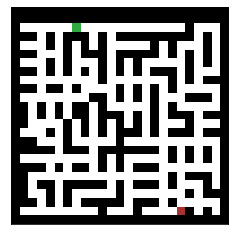
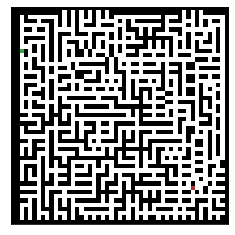


Main code

In [3]:
class grid:
    def __init__(self, N, S, F, p):
        
        ## Make sure start and end are within the grid
        assert N > 2
        assert S[0] < N
        assert S[1] < N
        assert F[0] < N
        assert F[1] < N

        assert S[0] > 0
        assert S[1] > 0
        assert F[0] > 0
        assert F[1] > 0

        self.N = N

        self.grid = np.zeros((N, N), dtype=np.int32)
        #print(len(self.grid))
        ## Surround the grid with obstacles
        self.grid[0, :] = 1
        self.grid[N - 1, :] = 1
        self.grid[:, 0] = 1
        self.grid[:, N - 1] = 1

        obstacle_free_points = {S, F}

        ### Fill the grid with obstacles. 
        ### An obstacle at position (x,y) -> grid[x,y]=1
        ### Ensure there is a path from S to F
        ### Your code here ###
        
        #find a random path by choosing a random adjacent node each time till you reach F
        pathSF = [S]
        adj_nodes = self.adjacent(S)
        shuffle(adj_nodes)
        adj_node = adj_nodes[0]
        pathSF.append(adj_node)
        while adj_node != F:
            adj_nodes = self.adjacent(adj_node)
            shuffle(adj_nodes)
            adj_node = adj_nodes[0]
            pathSF.append(adj_node)
        #print(pathSF)
        
        #now we need to remove the circles from the path
        newpath = pathSF.copy()     
        j = 0
        while j != len(newpath):
            k = len(newpath)-1
            while newpath[j] != newpath[k]:
                k -= 1
            newpath = newpath[0:j] + newpath[k:len(newpath)] 
            j += 1  
        #print(newpath)
        
        for i in range(1,N-1):
            for j in range(1,N-1):
                if(uniform(0,1) < p):
                    self.grid[i][j] = 1
        
        for i,j in newpath:
            self.grid[i][j] = 0
    
    def adjacent(self, node):
        adjacent_nodes = []
        for n in (node[0] - 1, node[1]), (node[0] + 1, node[1]), (node[0], node[1] - 1), (node[0], node[1] + 1):
            if self.grid[n] == 0:
                adjacent_nodes.append(n)
        return adjacent_nodes
        

    def draw_map(self, S=None, F=None, path=None):

        image = np.zeros((self.N, self.N, 3), dtype=int)

        image[self.grid == 0] = [255, 255, 255]
        image[self.grid == 1] = [0, 0, 0]
        if S:
            image[S] = [50, 168, 64]
        if F:
            image[F] = [168, 50, 50]
        if path:
            for n in path[1:-1]:
                image[n] = [66, 221, 245]

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.show()


Execution

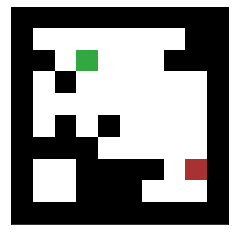

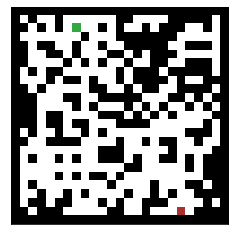

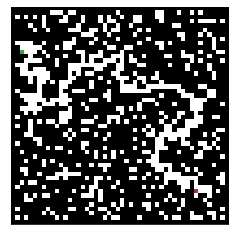

In [5]:
# show different grid sizes with different obstacle densities

for N, S, F, p in (11, (1, 3), (7, 8), .3), (25, (2, 7), (23, 19), .5), (51, (10, 2), (42, 42), .8):
    map = grid(N, S, F, p)
    map.draw_map(S, F)


## **Μέρος 2**

Στο δεύτερο μέρος του θέματος καλείστε να υλοποιήσετε διάφορους αλγορίθμους αναζήτησης για την εύρεση μονοπατιών μεταξύ δυο κόμβων και να τους εφαρμόσετε στους λαβυρίνθους του 1ου Μέρους. Για την εφαρμογή των αλγορίθμων καλείστε να κατασκευάσετε διάφορες συναρτήσεις κόστους τόσο για την μέτρηση του πραγματικού όσο και για την εκτίμηση των αποστάσεων από έναν κόμβο στον κόμβο στόχο (heuristic). Θα πρέπει να πειραματιστείτε με αυτές τις συναρτήσεις  με σκοπό να μελετήσετε το πώς αυτές επηρεάζουν την πολυπλοκότητα, τον χρόνο καθώς και το βέλτιστο μονοπάτι. Οι παραπάνω αλγόριθμοι καθώς και οι παραλλαγές τους θα εκτελεστούν σε λαβυρίνθους με διαφορετικά μεγέθη.<br>
Ένα παράδειγμα οπτικοποίησης της λειτουργίας του αλγορίθμου φαίνεται παρακάτω:
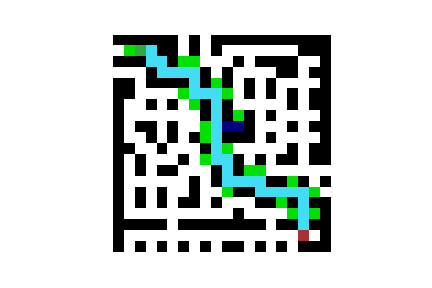

Σας δίνεται έτοιμη η κλαση visualization που υλοποιεί τις οπτικοποιήσεις, και παράδειγμα χρήσης της στο τέλος του notebook.

Οι αλγόριθμοι αναζήτησης που θα υλοποιήσετε θα στηριχτούν στον αλγόριθμο Α*, η γενική μορφή συνάρτησης κόστους του οποίου είναι:
$$f(n)=g(n)+h(n)$$
Η συνάρτηση $g(n)$ δίνει την πραγματική απόσταση από το σημείο εκκίνησης μέχρι τον κόμβο $n$, ενώ η συνάρτηση $h(n)$ δίνει μια ευριστική εκτίμηση της απόστασης από τον κόμβο $n$ μέχρι τον στόχο. Σας ζητείται να πειραματιστείτε με τις εξής επιλογές για τις δύο συναρτήσεις:
* $g(n)=0$ και $h(n)=\{\text{manhattan}(n),\text{euclidean}(n)\}$. Ποιος αλγόριθμος αναζήτησης προκύπτει; Μπορεί να βρει πάντα το βέλτιστο μονοπάτι;
* $g(n)=1$ και $h(n)=0$. Ποιος αλγόριθμος αναζήτησης προκύπτει; Μπορεί να βρει πάντα το βέλτιστο μονοπάτι;
* $g(n)=1$ και $h(n)=\{\text{manhattan}(n),\text{euclidean}(n)\}$. Ποιος αλγόριθμος αναζήτησης προκύπτει; Μπορεί να βρει πάντα το βέλτιστο μονοπάτι;

Μπορείτε να προτείνετε και άλλες ευριστικές συναρτήσεις εκτός από τις αποστάσεις manhattan και euclidean;


Main code

In [4]:
class Node():

    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position

    
class pathfinder:
    def __init__(self, S, F, grid, c, h):
        self.S = S  ## S is the starting point - a tuple (x,y)
        self.F = F  ## F is the goal
        self.grid = grid ## A grid object (from A)
        self.vis = visualization(S, F)
        self.path = []
        self.cost = c
        self.heuristic = h
        (self.path, self.expanded) = self.astar(self.grid, self.S, self.F, self.cost, self.heuristic)
    
    def astar(self, maze, start, end, c, h):
        # Create start and end node
        start_node = Node(None, start)
        start_node.g = start_node.h = start_node.f = 0
        end_node = Node(None, end)
        end_node.g = end_node.h = end_node.f = 0

        # Initialize both open and closed list
        open_list = []
        closed_list = []
        
        # Add the start node
        open_list.append(start_node)
        
        # Loop until you find the end
        while len(open_list) > 0:
            #print("in")
            current_node = open_list[0]
            current_index = 0
            for index, item in enumerate(open_list):
                if item.f < current_node.f:
                    current_node = item
                    current_index = index

            # Pop current off open list, add to closed list
            open_list.pop(current_index)
            closed_list.append(current_node)

            # Found the goal
            if current_node == end_node:
                path = []
                current = current_node
                while current is not None:
                    path.append(current.position)
                    current = current.parent
                return (path[::-1], expanded) # Return reversed path
             
            frontier = []
            expanded = []
            # Generate children
            children = []
            new_position = []
            new_position.extend(maze.adjacent(current_node.position))
            for i in new_position: # Adjacent squares
                # Create new node
                new_node = Node(current_node, i)

                # Append
                children.append(new_node)

            # Loop through children
            for child in children:
                # Child is on the closed list
                flag = False
                if child in closed_list:
                    continue

                # Create the f, g, and h values
                child.g = current_node.g + c(child.position[0], child.position[1])
                child.h = h(child.position[0], child.position[1], end)
                child.f = child.g + child.h

                # Child is already in the open list
                if child in open_list:
                    flag = True
                    for open_node in open_list:
                        if child == open_node and child.g < open_node.g:
                            flag = False

                if flag:
                    continue
                # Add the child to the open list
                open_list.append(child)
            
            for i in range(0, len(open_list)):
                frontier.append(open_list[i].position)
            for i in range(0, len(closed_list)):
                expanded.append(closed_list[i].position)
            self.vis.draw_step(maze, frontier, expanded)
                
    def get_path(self):
        return self.path
    
    def get_expanded(self):
        return self.expanded


Execution

Dijkstra g(n) = 1, h(n) = 0
Path length:  368


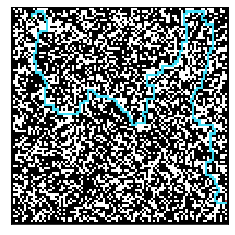

A* g(n) = 1, h(n) = euclidean(n)
Path length:  368


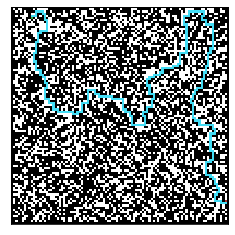

A* g(n) = 1 h(n) = manhattan(n)
Path length:  368


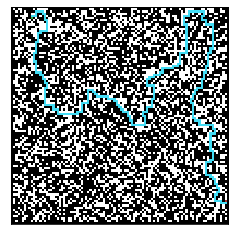

Best First g(n) = 0, h(n) = euclidean(n)
Path length:  376


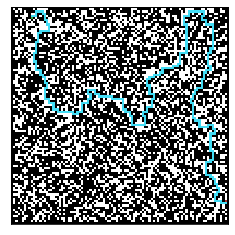

Best First g(n) = 0, h(n) = manhattan(n)
Path length:  384


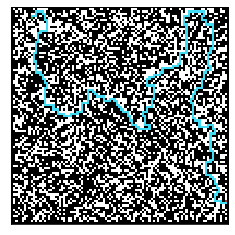

In [7]:
N = 100
S = (5, 9)
F = (98, 85)
p = .6

map = grid(N, S, F, p)
pf = pathfinder(S, F, map, lambda x, y : 1, lambda x, y, F : 0)
print("Dijkstra g(n) = 1, h(n) = 0")
print("Path length: ", len(pf.get_path()))
map.draw_map(S, F, pf.get_path())
pf = pathfinder(S, F, map, lambda x, y: 1, lambda x, y, F: np.sqrt((x-F[0])*(x-F[0]) + (y-F[1])*(y-F[1])))
print("A* g(n) = 1, h(n) = euclidean(n)")
print("Path length: ", len(pf.get_path()))
map.draw_map(S, F, pf.get_path())
pf = pathfinder(S, F, map, lambda x, y: 1, lambda x, y, F: abs(x-F[0]) + abs(y-F[1]))
print("A* g(n) = 1 h(n) = manhattan(n)")
print("Path length: ", len(pf.get_path()))
map.draw_map(S, F, pf.get_path())
pf = pathfinder(S, F, map, lambda x, y: 0, lambda x, y, F: np.sqrt((x-F[0])*(x-F[0]) + (y-F[1])*(y-F[1])))
print("Best First g(n) = 0, h(n) = euclidean(n)")
print("Path length: ", len(pf.get_path()))
map.draw_map(S, F, pf.get_path())
pf = pathfinder(S, F, map, lambda x, y: 0, lambda x, y, F: abs(x-F[0]) + abs(y-F[1]))
print("Best First g(n) = 0, h(n) = manhattan(n)")
print("Path length: ", len(pf.get_path()))
map.draw_map(S, F, pf.get_path())


### **Observations - Conclusions**

Παραπάνω γίνεται χρήση του αλγόριθμου Α* με συνάρτηση κόστους: f(n)=g(n)+h(n)

#### 1η περίπτωση
Για g(n)=0 και h(n)={manhattan(n), euclidean(n)}, προκύπτει ο αλγόριθμος που ακολουθεί μόνο την ευριστική συνάρτηση αναζήτησης. Αυτός ο αλγόριθμος λέγεται Best First, και βρίσκει πάντα μονοπάτι, χωρίς όμως να εγγυάται ότι αυτό είναι το βέλτιστο. Επομένως, η πορεία που θα ακολουθήσει ο αλγόριθμος αυτός καθορίζεται από την συμπεριφορά της συνάρτησης αυτής, η οποία προσπαθεί να φτάσει στον στόχο όσο το δυνατόν πιο γρηγορά. Είτε είναι με απόσταση Ευκλείδεια είτε με απόσταση Manhattan, ο αλγόριθμος Α* μετατρέπεται σε έναν greedy αλγόριθμο, που δίνει προτεραιότητα σε οποία κατάσταση “θεωρεί” ότι είναι πιο κοντά στον στόχο, γεγονός που δεν είναι ούτε complete, ούτε optimal.

#### 2η περίπτωση
Για g(n)=1 και h(n)=0, προκύπτει ο αλγόριθμος αναζήτησης Branch and Bound. Συγκεκριμένα, είναι μια ειδική περίπτωση του αλγορίθμου Α, ο αλγόριθμος του Dijkstra, ή αλλιώς ο αλγόριθμος Uniform Cost Search. Ακριβώς επειδή ο Α* δεν έχει κάποια “γνώση” για την απόσταση των καταστάσεων που επισκέπτεται ως προς τον στόχο, πρέπει να δίνει προτεραιότητα στο μικρότερο κόστος των καταστάσεων. Συνεπώς, αυτό που δημιουργείται είναι ένα μέτωπο που “ανοίγει” προς όλες τις κατευθύνσεις, με ίδιο τρόπο, σαν πλημμύρα. Εφόσον στην προκείμενη περίπτωση το κόστος είναι ίδιο για όλες τις καταστάσεις (ίσο με 1) ο αλγόριθμος αυτός εκφυλίζεται σε UCS με κόστος 1, δηλαδή BFS, δηλαδή αλγόριθμο πλημμύρας. Ο αλγόριθμος αυτός είναι και optimal και complete, καθώς θα επισκεφθεί όλες τις καταστάσεις, και μάλιστα με προτεραιότητα το πραγματικό κόστος. Παρ’ όλο που είναι βέλτιστος και πλήρης, δεν είναι γρήγορος. καθώς η φύση του αλγορίθμου τον υποχρεώνει να επισκέπτεται πάρα πολλές καταστάσεις που είναι άχρηστες.

#### 3η περίπτωση
Για g(n)=1 και h(n)={manhattan(n), euclidean(n)}, προκύπτει ο αλγόριθμος αναζήτησης Α*, ο οποίος μπορεί να βρει πάντα το βέλτιστο μονοπάτι. Όταν ο αλγόριθμος Α* έχει και ευριστική συνάρτηση και συνάρτηση κόστους, είναι ο κλασσικός αλγόριθμος Α*. Αν η συνάρτηση αυτή είναι admissible τοτε ο αλγόριθμος Α* είναι optimal. Σαν αλγόριθμος είναι ούτως ή άλλως πλήρης, αλλά η καλή ευριστική συνάρτηση τον ξεχωρίζει από τον UCS. Αν μια ευριστική συνάρτηση είναι consistent θα είναι και admissible. Οι συναρτήσεις αποστάσεων manhattan και euclidean είναι admissible, άρα ο αλγόριθμος είναι optimal και complete.

#### Προτεινόμενη περίπτωση
Μια άλλη συνάρτηση που θα μπορούσε να λειτουργήσει ως ευρετικό κριτήριο είναι πιθανόν η πυκνότητα εμποδίων γύρω από την κατάσταση που βρίσκεται κάθε φορά ο αλγόριθμος, με παράμετρο την ακτίνα γύρω από την κατάσταση που βρίσκεται για να οριστεί η πυκνότητα εμποδίων της “γειτονίας”. Αν και σαν ιδέα είναι σχετικά απλή, δεν είναι ξεκάθαρο στο πλαίσιο αυτής της άσκησης για το αν είναι admissible κριτήριο για να βγει συμπέρασμα για την συμπεριφορά του αλγορίθμου. Πιθανόν κάποιο άλλο κριτήριο που να μελετάει την περιοχή που είναι “κοντά” στην περιοχή που εξετάζεται και να εξάγει κάποιο μετρικό να είναι χρήσιμη. Τέλος, μια άλλη ευριστική συνάρτηση εκτός από τις αποστάσεις manhattan και euclidean, είναι η Diagonal Distance, η οποία είναι το μέγιστο των απόλυτων διαφορών των συντεταγμένων του κόμβου n από τον κόμβο-στόχο (αυτή η ευριστική συνάρτηση χρησιμοποιείται όταν δύναται η κίνηση μόνο προς τις 8 κατευθύνσεις):

h(n) = max { abs(x – F[0]), abs(y – F[1]) }

Η απόσταση αυτή υπολογίζεται ως: <br>
    function heuristic(node) = <br>
    dx = abs(node.x - goal.x) <br>
    dy = abs(node.y - goal.y) <br>
    return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy) <br>
όπου σε μας το D = κόστος να κινηθούμε "σταυρωτά" = 1 και D2 = κόστος να κινηθούμε διαγώνια <br>
Θα μπορούσαμε να χρησιμοποιήσουμε και την ευκλίδεια απόσταση στο τετράγωνο αλλά αυτό μόνο στις περιπτώσεις που το g(n) = 0 για να βγουν σωστά αποτελέσματα.

## **Μέρος 3**

Στο τρίτο μέρος του θέματος θα θεωρήσετε ότι, για τα κελιά του λαβυρίνθου που δεν έχουν εμπόδιο, το κόστος μετάβασης σε αυτά είναι τυχαίο, παίρνει τιμές στο $(0,1)$ και ακολουθεί κάποια γνωστή κατανομή. Συγκεκριμένα:
- Καλείστε να τροποποιήσετε τον κώδικα του πρώτου μέρους ώστε να ανατίθενται τυχαία τα κόστη στα κελιά που δεν έχουν εμπόδια, δεδομένης της κατανομής. (Επιλέξτε τρεις γνωστές κατανομές)
- Καλείστε να τροποποιήσετε τον κώδικα του δεύτερου μέρους ώστε να λαμβάνονται υπόψη τα νέα κόστη μετάβασης στους αλγορίθμους αναζήτησης.
- Καλείστε να μελετήσετε τη συμπεριφορά των διαφορετικών αλγορίθμων αναζήτησης και ευριστικών ανάλογα με την εκάστοτε κατανομή των κοστων μεταβασης.

Συγκεκριμένα για το ερώτημα αυτό θα πρέπει να κατασκευάσετε γραφικές παραστάσεις για το μήκος του ελάχιστου μονοπατιού ως προς το μέγεθος του χάρτη καθώς και για το πλήθος των κόμβων που επεκτείνονται ως προς το μέγεθος του χάρτη, για κάθε συνδυασμό κατανομής κόστους και ευριστικής συνάρτησης. 

Τι συμπεράσματα προκύπτουν για τη λειτουργία των αλγορίθμων σε αυτήν την περίπτωση; Ποια θα ήταν τα αποτελέσματα εάν το τυχαίο κόστος μετάβασης ήταν στο διάστημα $(1,2)$; Ποια θα ήταν τα αποτελέσματα εάν το τυχαίο κόστος μετάβασης ήταν στο διάστημα $[0, 0.1)$;

Ακολουθούν δύο παραδείγματα γραφικών παραστάσεων:

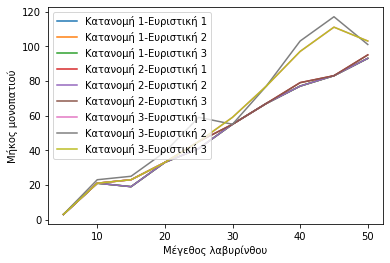
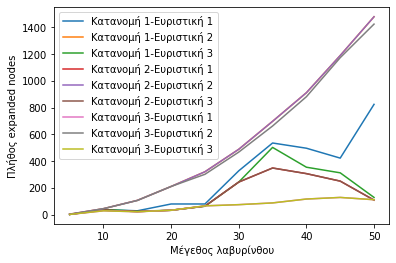


Main code - Execution

10
20
30
40
50
60
70
80
90
100


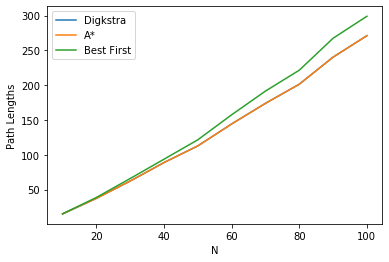

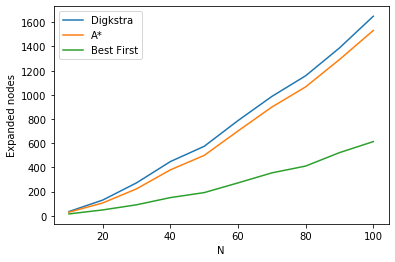

0
1
2
3
4
5
6
7
8
9
10


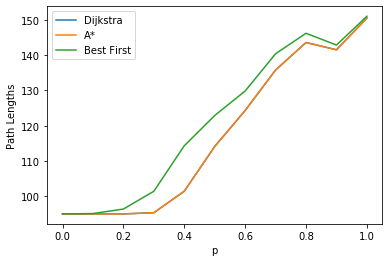

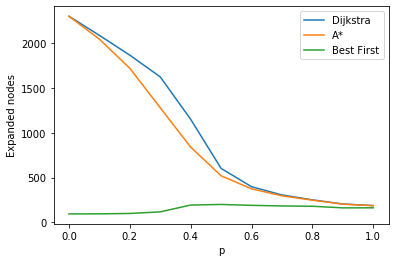

In [11]:
# your code goes here
p = .5
S = (1, 1)
dijkstra_shortest_lengths_N_mean = np.zeros(10)
astar_shortest_lengths_N_mean = np.zeros(10)
bestfirst_shortest_lengths_N_mean = np.zeros(10)
dijkstra_expanded_N_mean = np.zeros(10)
astar_expanded_N_mean = np.zeros(10)
bestfirst_expanded_N_mean = np.zeros(10)
for N in range(10,110,10):
    #print(N)
    F = (N-2, N-2)
    dijkstra_shortest_lengths_N = []
    astar_shortest_lengths_N = []
    bestfirst_shortest_lengths_N = []
    dijkstra_expanded_N = []
    astar_expanded_N = []
    bestfirst_expanded_N = []
    for i in range(0,100):
        map = grid(N, S, F, p)
        pf = pathfinder(S, F, map, lambda x, y : 1, lambda x, y, F : 0)
        dijkstra_shortest_lengths_N.append(len(pf.get_path()))
        dijkstra_expanded_N.append(len(pf.get_expanded()))
        pf = pathfinder(S, F, map, lambda x, y : 1, lambda x, y, F : np.sqrt((x-F[0])*(x-F[0]) + (y-F[1])*(y-F[1])))
        astar_shortest_lengths_N.append(len(pf.get_path()))
        astar_expanded_N.append(len(pf.get_expanded()))
        pf = pathfinder(S, F, map, lambda x, y : 0, lambda x, y, F : np.sqrt((x-F[0])*(x-F[0]) + (y-F[1])*(y-F[1])))
        bestfirst_shortest_lengths_N.append(len(pf.get_path()))
        bestfirst_expanded_N.append(len(pf.get_expanded()))
    dijkstra_shortest_lengths_N_mean[int(N/10)-1] = np.mean(dijkstra_shortest_lengths_N)
    astar_shortest_lengths_N_mean[int(N/10)-1] = np.mean(astar_shortest_lengths_N)
    bestfirst_shortest_lengths_N_mean[int(N/10)-1] = np.mean(bestfirst_shortest_lengths_N)
    dijkstra_expanded_N_mean[int(N/10)-1] = np.mean(dijkstra_expanded_N)
    astar_expanded_N_mean[int(N/10)-1] = np.mean(astar_expanded_N)
    bestfirst_expanded_N_mean[int(N/10)-1] = np.mean(bestfirst_expanded_N)
    

plt.plot(list(range(10, 110, 10)), dijkstra_shortest_lengths_N_mean, label = "Digkstra")
plt.plot(list(range(10, 110, 10)), astar_shortest_lengths_N_mean, label = "A*")
plt.plot(list(range(10, 110, 10)), bestfirst_shortest_lengths_N_mean, label = "Best First")
plt.xlabel("N")
plt.ylabel("Path Lengths")
plt.legend()
plt.show()

plt.plot(list(range(10, 110, 10)), dijkstra_expanded_N_mean, label = "Digkstra")
plt.plot(list(range(10, 110, 10)), astar_expanded_N_mean, label = "A*")
plt.plot(list(range(10, 110, 10)), bestfirst_expanded_N_mean, label = "Best First")
plt.xlabel("N")
plt.ylabel("Expanded nodes")
plt.legend()
plt.show()


N = 50
F = (N-2, N-2)
p = 0
dijkstra_shortest_lengths_p_mean = np.zeros(11)
astar_shortest_lengths_p_mean = np.zeros(11)
bestfirst_shortest_lengths_p_mean = np.zeros(11)
dijkstra_expanded_p_mean = np.zeros(11)
astar_expanded_p_mean = np.zeros(11)
bestfirst_expanded_p_mean = np.zeros(11)
for j in range(0,11):
    #print(j)
    dijkstra_shortest_lengths_p = []
    astar_shortest_lengths_p = []
    bestfirst_shortest_lengths_p = []
    dijkstra_expanded_p = []
    astar_expanded_p = []
    bestfirst_expanded_p = []
    for i in range(0,100):
        #print(i)
        map = grid(N, S, F, p)
        pf = pathfinder(S, F, map, lambda x, y : 1, lambda x, y, F : 0)
        dijkstra_shortest_lengths_p.append(len(pf.get_path()))
        dijkstra_expanded_p.append(len(pf.get_expanded()))
        pf = pathfinder(S, F, map, lambda x, y : 1, lambda x, y, F : np.sqrt((x-F[0])*(x-F[0]) + (y-F[1])*(y-F[1])))
        astar_shortest_lengths_p.append(len(pf.get_path()))
        astar_expanded_p.append(len(pf.get_expanded()))
        pf = pathfinder(S, F, map, lambda x, y : 0, lambda x, y, F : np.sqrt((x-F[0])*(x-F[0]) + (y-F[1])*(y-F[1])))
        bestfirst_shortest_lengths_p.append(len(pf.get_path()))
        bestfirst_expanded_p.append(len(pf.get_expanded()))
    dijkstra_shortest_lengths_p_mean[j] = np.mean(dijkstra_shortest_lengths_p)
    astar_shortest_lengths_p_mean[j] = np.mean(astar_shortest_lengths_p)
    bestfirst_shortest_lengths_p_mean[j] = np.mean(bestfirst_shortest_lengths_p)
    dijkstra_expanded_p_mean[j] = np.mean(dijkstra_expanded_p)
    astar_expanded_p_mean[j] = np.mean(astar_expanded_p)
    bestfirst_expanded_p_mean[j] = np.mean(bestfirst_expanded_p)
    p += 0.1

plt.plot(list(np.arange(0, 1.1, 0.1)), dijkstra_shortest_lengths_p_mean, label = "Dijkstra")
plt.plot(list(np.arange(0, 1.1, 0.1)), astar_shortest_lengths_p_mean, label = "A*")
plt.plot(list(np.arange(0, 1.1, 0.1)), bestfirst_shortest_lengths_p_mean, label = "Best First")
plt.xlabel("p")
plt.ylabel("Path Lengths")
plt.legend()
plt.show()

plt.plot(list(np.arange(0, 1.1, 0.1)), dijkstra_expanded_p_mean, label = "Dijkstra")
plt.plot(list(np.arange(0, 1.1, 0.1)), astar_expanded_p_mean, label = "A*")
plt.plot(list(np.arange(0, 1.1, 0.1)), bestfirst_expanded_p_mean, label = "Best First")
plt.xlabel("p")
plt.ylabel("Expanded nodes")
plt.legend()
plt.show()

### **Conclusions for the graph depictions**
Παρατηρούμε ότι όσο αφορά τo συντομότερο μονοπάτι με παραμετρους το Ν και p τα αποτελέσματα στις γραφικές για τους Dijkstra και A* είναι τα ίδια. Αυτό είναι κάτι που περιμέναμε αφού και οι δύο καταλήγουν σε βέλτιστο μονοπάστι από τον S στον F που έχει το ίδιο μήκος. Όσο αφορά τον Best First αλγόριθμο φαίνεται από τη γραφική του μήκους των μονοπατιών συναρτήση των p και N ότι δεν βρίσκει το συντομότερο μονοπάτι, αφού έχει μεγαλύτερο μήκος από αυτό των άλλων αλγορίθμων. Ίσως να το βρει για μικρότερα Ν και p. Προφανώς όσο αυξάνεται το μήκος του χάρτη, αυξάνεται και το μήκος των μονοπατιών και για τους τρεις αλγόριθμους. Το ίδιο ισχύει και όταν αυξάνεται η πυκνότητα των εμποδίων. <br>
Όσο αφορά την πολυπλοκότητα των αλγορίθμων παρατηρώντας τα expanded nodes συναρτήση των p και N συμπεραίνουμε ότι ο Dijkstra έχει πιο μεγάλη πολυπλοκότητα από τον A* αφού ελέγχει για συντομότερο μονοπάτι περισσότερους κόμβους, άρα παράγει περισσότερους expanded nodes. Ο Best First από την άλλη έχει την μικρότερη πολυπλοκότητα αφού ελέγχει πολύ πιο λίγους κόμβους για να βρει ένα μονοπάτι. <br>
Από τις γραφικές παρατηρούμε ότι όσο αυξάνεται το μέγεθος του χάρτη(Ν), αυξάνονται και τα expanded nodes των αλγορίθμων πράγμα λογικό αφού τώρα ψάχνουμε μεγαλύτερο μονοπάτι. Επίσης για τους αλγόριθμους Dijkstra και Α* αυτή η αύξηση είναι πιο μέγαλη από τον Best First ο οποίος βλέποντας μόνο την ευριστική απόσταση θα κρατήσει πιο λίγους expanded nodes. <br>
Όσο αυξάνεται η πυκνότητα των εμποδίων(p) παρατηρούμε ότι τα expanded nodes μειώνονται στους Dijkstra και A* αφού τώρα δεν υπάρχουν πολλές επιλογές στις κινήσεις που μπορούν να κάνουν για να βρουν μονοπάτι. Όσο αφορά τον Best First τα expanded nodes παραμένουν κάπως σταθερά αφού δεν τον επιρρεάζει η πυκνότητα των εμποδίων για την εύρεση του μονοπατιού.

**Συμπεράσματα (1)**

Όπως φαίνεται στις παρακάτω γραφικές παραστάσεις, το βέλτιστο μονοπάτι επηρεάζεται, όπως είναι αναμενόμενο, από το μέγεθος του χάρτη και το μήκος του μεγαλώνει για μεγαλύτερα Ν, με τη σχέση των δύο μεγεθών να είναι σχεδόν γραμμική. Οι αλγόριθμοι Branch and Bound και A* έχουν την ίδια γραφική παράσταση μιας και οι δύο υπολογίζουν το βέλτιστο πονοπάτι, ενώ ο αλγόριθμος Best First βρίσκει λύση, η οποία δεν είναι βέλτιστη. Για μεγαλύτερα Ν, η λύση που υπολογίζει ο Best First έχει μεγαλύτερη διαφορά από το βέλτιστο μονοπάτι.

Για μεγαλύτερο μέγεθος χάρτη, η πολυπλοκότητα σχεδόν αυξάνεται εκθετικα, με τον αλγόριθμο Branch and Bound να παρουσιάζει τη μεγαλύτερη αύξηση, ενώ τον Best First να παραμένει σχεδόν σταθερός.

**Συμπεράσματα (2)**

Για μεγαλύτερη πυκνότητα εμποδίων, το μήκος του βέλτιστου μονοπατιού αυξάνεται εκθετικά, με τους Branch and Bound να έχουν την ίδια γραφική παράσταση αφού υπολογίζουν το βέλτιστο μονοπάτι, ενώ για μεγαλύτερες πυκνότητες εμποδίων, ο Best First πλησιάζει όλο και περισσότερο τη βέλτιστη λύση. Αυτό είναι αναμενόμενο, καθώς για μεγαλύτερες πυκνότητες εμποδίων, υπάρχουν λιγότερα εναλλακτικά μονοπάτια από τον κόμβο S προς τον F.
H πολυπλοκότητα των αλγορίθμων Branch and Bound και Α* μειώνεται με την αύξηση της πυκνότητας των εμποδίων, ενώ του Best First αυξάνεται. Όσο οι τιμές της πιθανότητας αυξάνονται, οι τιμές της πολυπλοκότητας των τριών αλγορίθμων έχουν όλο και μικρότερη διαφορά, μιας και για πυκνότερους χάρτες τα πιθανά μονοπάτια είναι λιγότερα και άρα και οι κόμβοι που επεκτείνονται - η πολυπλοκότητα των αλγορίθμων.

### **Παράδειγμα χρήσης της κλάσης Οπτικοποίησης**

Παράδειγμα χρήσης της κλάσης Οπτικοποίησης

``` #Ορίζουμε τα χαρακτηριστικά του χάρτη
N= 6
S = (1, 2)
F = (4, 4)
p = 0
map = grid(N, S, F) #αρχικοποίούμε τον χάρτη
map.grid[1, 1:5] = [0, 0, 0, 0]#σχεδιάζουμε κάποια μονοπάτια 
map.grid[1:5, 3] = [0, 0, 0, 0]#χειροκίνητα γιατί ο default αλγόριθμος grid επιστρέφει παντού
map.grid[1:5, 4] = [0, 0, 0, 0]#εμπόδια, όταν κάνετε τις αλλάγες σας αυτό δεν χρειάζεται 
#ορίζουμε το αντικείμενο που θα βρεί την βέλτιστη διαδρομή
#σε αυτό ορίζεται και ένα instance της κλάσης visualization με το όνομα vis
pf = pathfinder(S, F, map, lambda x, y: 1, lambda x, y: 0)


#σε κάθε βήμα του αλγορίθμου pathfinding θα εκτελούνται τα παρακάτω
frontier =  [(1, 3), (2, 2), (1, 1)] # θα βρίσκουμε το μέτωπο αναζήτησης
expanded_nodes =  [(1, 2)] # θα βρίσκουμε τους κόμβους που έχουν ήδη επεκταθεί
#καλούμε την παρακάτω μέθοδο για να εισάγουμε αυτό το frame στο animation
pf.vis.draw_step(map, frontier, expanded_nodes) #σχεδίαση ένος frame

#κάνουμε το παραπάνω για κάθε βήμα της αναζήτησης
frontier =  [(1, 4), (2, 3), (2, 2), (1, 1)]
expanded_nodes =  [(1, 2), (1, 3)]
pf.vis.draw_step(map, frontier, expanded_nodes) #σχεδίαση επόμενου frame

frontier =  [(2, 4), (2, 3), (2, 2), (1, 1)]
expanded_nodes =  [(1, 2), (1, 3), (1, 4)]
pf.vis.draw_step(map, frontier, expanded_nodes) #σχεδίαση επόμενου frame

frontier =  [(3, 4), (2, 3), (2, 2), (1, 1)]
expanded_nodes =  [(1, 2), (1, 3), (2, 4), (1, 4)]
pf.vis.draw_step(map, frontier, expanded_nodes) #σχεδίαση επόμενου frame

frontier =  [(4, 4), (2, 3), (2, 2), (3, 3), (1, 1)]
expanded_nodes =  [(1, 2), (1, 3), (1, 4), (3, 4), (2, 4)]
pf.vis.draw_step(map, frontier, expanded_nodes) #σχεδίαση επόμενου frame

#εισάγουμε το Path στο animation
path = [(1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
pf.vis. add_path(path)

#καλούμε την μέθοδο για να παρουσιάσουμε το animation στο Notebook
pf.vis.show_gif(fps = 1)

#αν θέλουμε μπορούμε και να το αποθηκεύσουμε τοπικά
# pf.vis.save_gif("mygif.gif")

#ή μπορούμε να παρουσιάσουμε μόνο το τελευταίο frame, όπου φαίνονται όλοι οι κόμβοι που έχουν επεκταθεί μαζί με το τελευταίο μέτωπο
#και το βέλτιστο μονοπάτι
# pf.vis.show_last_frame()
```

Dijkstra g(n) = 1, h(n) = 0
A* g(n) = 1, h(n) = euclidean(n)
Best First g(n) = 0, h(n) = euclidean(n)


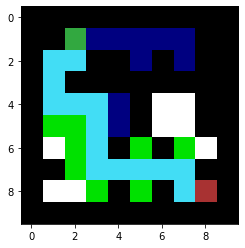

In [5]:
#Ορίζουμε τα χαρακτηριστικά του χάρτη
N = 6
S = (1, 2)
F = (4, 4)
p = 0
map = grid(N, S, F, p) 
#αρχικοποίούμε τον χάρτη
#ορίζουμε το αντικείμενο που θα βρεί την βέλτιστη διαδρομή
#σε αυτό ορίζεται και ένα instance της κλάσης visualization με το όνομα vis

print("Dijkstra g(n) = 1, h(n) = 0")
pf = pathfinder(S, F, map, lambda x, y: 1, lambda x, y, F: 0)
pf.vis.add_path(pf.get_path())
pf.vis.show_gif(fps = 1)
pf.vis.show_last_frame()
#pf.vis.save_gif("mygif1.gif")
print("A* g(n) = 1, h(n) = euclidean(n)")
pf = pathfinder(S, F, map, lambda x, y: 1, lambda x, y, F: np.sqrt((x-F[0])*(x-F[0]) + (y-F[1])*(y-F[1])))
pf.vis.add_path(pf.get_path())
pf.vis.show_gif(fps = 1)
pf.vis.show_last_frame()
#pf.vis.save_gif("mygif2.gif")
print("Best First g(n) = 0, h(n) = euclidean(n)")
pf = pathfinder(S, F, map, lambda x, y: 0, lambda x, y, F: np.sqrt((x-F[0])*(x-F[0]) + (y-F[1])*(y-F[1])))
pf.vis.add_path(pf.get_path())
pf.vis.show_gif(fps = 1)
pf.vis.show_last_frame()
#αν θέλουμε μπορούμε και να το αποθηκεύσουμε τοπικά
#pf.vis.save_gif("mygif3.gif")

#ή μπορούμε να παρουσιάσουμε μόνο το τελευταίο frame, όπου φαίνονται όλοι οι κόμβοι που έχουν επεκταθεί μαζί με το τελευταίο μέτωπο
#και το βέλτιστο μονοπάτι


### **Conclusion**
Παρατηρώντας τα αποτελέσματα του visualization μπορούμε να καταλήξουμε στα ίδια συμπεράσματα όσο αφορά την πολυπλοκότητα των αλγορίθμων. Βλέπωντας τα gif που παράγονται συμπεραίνουμε ότι ο Dijkstra έχει μεγαλύτερη πολυπλοκότητα αφού χρειάζεται περισσότερα βήματα για να καταλήξει στο μονοπάτι. Μετά ακολουθέι ο Α* και τελος ο Best First.

**END**